# DT-HMM Training

In [1]:
import pandas as pd
import numpy as np
import yaml
import os
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import plotly.express as px

In [2]:
USE_ONLY_SEQUENCES_GT_TWO = False
DATASET = "relapse"
SAVE_MODEL_AND_RESULTS = True

## Import Configs and Load Preprocessed Data

In [3]:
with open((impresources.files(configs) / 'model_config.yaml')) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [4]:
base_training_data_path = data_config['training_data'][DATASET]['preprocessed_path']
print(f"{base_training_data_path}")

/workspaces/master-thesis-recurrent-health-events-prediction/data/avh-data-preprocessed


In [5]:
training_data_path = base_training_data_path + "/multiple_relapses_patients"

In [6]:
from recurrent_health_events_prediction.training.utils_hmm import load_and_prepare_historical_data_relapse, load_and_prepare_historical_data_mimic

if DATASET == "mimic":
    X, filepath_historical_events = load_and_prepare_historical_data_mimic(training_data_path, use_only_sequences_gt_2_steps=USE_ONLY_SEQUENCES_GT_TWO)
else:
    X, filepath_historical_events = load_and_prepare_historical_data_relapse(training_data_path, use_only_sequences_gt_2_steps=USE_ONLY_SEQUENCES_GT_TWO)

Loading data from:  /workspaces/master-thesis-recurrent-health-events-prediction/data/avh-data-preprocessed/multiple_relapses_patients/historical_relapses.csv
Data loaded successfully. Preparing data...
Using all sequences, including those with 1 step.


In [7]:
model_trained = False

### Distribution of Data

In [8]:
if DATASET == "mimic":
    hospitaliaztions_count = X.groupby('SUBJECT_ID').size().reset_index(name='HOSPITALIZATIONS_COUNT')

    # Plot the distribution of Previos Number of Hospitalizations
    fig = px.histogram(hospitaliaztions_count, x='HOSPITALIZATIONS_COUNT', marginal='violin',
                    labels={'TOTAL_HOSPITALIZATIONS': 'Total Number of Hospitalizations'})
    fig.update_layout(title="Distribution of Total Number of Hospitalizations", yaxis_title="Count")
    fig.show()

    X.TOTAL_HOSPITALIZATIONS.describe()
else:
    relapses_count = X.groupby('DONOR_ID').size().reset_index(name='RELAPSES_COUNT')

    # Plot the distribution of Previous Number of Relapses
    fig = px.histogram(relapses_count, x='RELAPSES_COUNT', marginal='violin',
                    labels={'RELAPSES_COUNT': 'Total Number of Relapses'})
    fig.update_layout(title="Distribution of Total Number of Relapses", yaxis_title="Count")
    fig.show()

## Import Specific Model Config (Optional)

In [9]:
model_name = "hmm_categorical_relapse_time"
base_dir = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm"
model_dir = os.path.join(base_dir, model_name)
config_path = os.path.join(model_dir, f"{model_name}_config.yaml")
with open(config_path, 'r') as f:
    hmm_config = yaml.safe_load(f)

In [10]:
hmm_config

{'continuous_event_time_col': 'LOG_TIME_UNTIL_NEXT_POSITIVE',
 'event_id_col': 'COLLECTION_ID',
 'event_name': 'relapse',
 'event_time_cat_col': 'RELAPSE_DURATION_CATEGORY',
 'event_time_cat_order': ['0-30', '30-90', '90-180', '180+'],
 'add_distribution_params': {'RELAPSE_DURATION_CATEGORY_ENCODED': {'labels': ['0-30',
    '30-90',
    '90-180',
    '180+'],
   'n_categories': 4}},
 'event_time_feature_col': 'RELAPSE_DURATION_CATEGORY_ENCODED',
 'feature_define_state_labels': 'RELAPSE_DURATION_CATEGORY_ENCODED',
 'features': {'LOG_TIME_SINCE_LAST_POSITIVE': 'gaussian',
  'NUM_POSITIVES_SINCE_LAST_NEGATIVE': 'poisson',
  'RELAPSE_DURATION_CATEGORY_ENCODED': 'categorical'},
 'hidden_state_labels': ['high', 'medium', 'low'],
 'id_col': 'DONOR_ID',
 'model_name': 'hmm_categorical_relapse_time',
 'n_states': 3,
 'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm',
 'time_col': 'RELAPSE_START',
 'use_only_sequences_gte_2_steps': False}

In [11]:
event_name = hmm_config["event_name"]
event_time_cat_col = hmm_config["event_time_cat_col"]
event_time_cat_order = hmm_config["event_time_cat_order"]
continuous_event_time_col = hmm_config["continuous_event_time_col"]
subject_id_col = hmm_config["id_col"]
event_id_col = hmm_config["event_id_col"]
apply_power_transform = hmm_config.get("apply_power_transform", False)

print("HMM model configuration loaded from file:")
print(f"Number of states: {hmm_config['n_states']}")
print("Features used for HMM:")
for feature, dist in hmm_config["features"].items():
    print(f"- {feature}: {dist}")

HMM model configuration loaded from file:
Number of states: 3
Features used for HMM:
- LOG_TIME_SINCE_LAST_POSITIVE: gaussian
- NUM_POSITIVES_SINCE_LAST_NEGATIVE: poisson
- RELAPSE_DURATION_CATEGORY_ENCODED: categorical


## Fit the model

In [12]:
save_dir = os.path.join(hmm_config["save_model_path"], hmm_config["model_name"])
print("Save directory:", save_dir)
os.makedirs(save_dir, exist_ok=True)

Save directory: /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time


In [13]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM

features = hmm_config["features"]
model_name = hmm_config["model_name"]

n_states = hmm_config["n_states"]
labels = hmm_config["hidden_state_labels"]

hmm = RecurrentHealthEventsHMM(hmm_config, n_states=n_states, features=features)

In [14]:
print("Model name: ", model_name)
print("Number of hidden states: ", n_states)
print("Features: ", features)

Model name:  hmm_categorical_relapse_time
Number of hidden states:  3
Features:  {'LOG_TIME_SINCE_LAST_POSITIVE': 'gaussian', 'NUM_POSITIVES_SINCE_LAST_NEGATIVE': 'poisson', 'RELAPSE_DURATION_CATEGORY_ENCODED': 'categorical'}


In [15]:
X[features.keys()].describe()

,LOG_TIME_SINCE_LAST_POSITIVE,NUM_POSITIVES_SINCE_LAST_NEGATIVE,RELAPSE_DURATION_CATEGORY_ENCODED
count,38183.000000,38183.000000,38183.000000
mean,2.001221,3.161512,0.487468
std,0.911144,6.405519,0.810073
min,0.693147,1.000000,0.000000
25%,1.386294,1.000000,0.000000
50%,1.945910,1.000000,0.000000
75%,2.484907,3.000000,1.000000
max,5.187386,221.000000,3.000000


In [16]:
print("Number of sequences: ", len(hmm.transform_dataframe(X)))
print("Number of events: ", len(X))

Number of sequences:  12289
Number of events:  38183


In [17]:
if apply_power_transform:
    X = hmm.fit_transform_power_variables(X)

In [18]:
X[[subject_id_col] + list(features.keys())].head()

,DONOR_ID,LOG_TIME_SINCE_LAST_POSITIVE,NUM_POSITIVES_SINCE_LAST_NEGATIVE,RELAPSE_DURATION_CATEGORY_ENCODED
0,10141,2.197225,1.0,0
1,10141,3.931826,2.0,1
2,10141,1.945910,2.0,0
3,10141,2.564949,1.0,0
4,10173,1.386294,1.0,0


In [19]:
print("Example of transformed data: ")
hmm.transform_dataframe(X)[:2]

Example of transformed data: 


[[[2, 1, 0], [4, 2, 1], [2, 2, 0], [3, 1, 0]], [[1, 1, 0]]]

In [20]:
sequence_legth_list = []

for seq in hmm.transform_dataframe(X):
    if len(seq) == 1 and USE_ONLY_SEQUENCES_GT_TWO:
        print("Sequence with only one event found. This is not expected in the training data.")
        print(seq)
    sequence_legth_list.append(len(seq))

print("Average sequence length: ", np.mean(sequence_legth_list))
print("Minimum sequence length: ", np.min(sequence_legth_list))
print("Maximum sequence length: ", np.max(sequence_legth_list))
print("Number of sequences with length 2: ", sequence_legth_list.count(2))


Average sequence length:  3.107087639352266
Minimum sequence length:  1
Maximum sequence length:  75
Number of sequences with length 2:  2561


In [21]:
initialize_from_first_obs_with_gmm = True
hmm.train(X, verbose=True, random_state=56, initialize_from_first_obs_with_gmm=initialize_from_first_obs_with_gmm)
model_trained = True

Initializing model with first observations using GMM...
[1] Improvement: 143.00390625, Time: 0.00896s
[2] Improvement: 55.93359375, Time: 0.00863s
[3] Improvement: 30.34765625, Time: 0.007876s
[4] Improvement: 19.30859375, Time: 0.009353s
[5] Improvement: 13.5859375, Time: 0.009701s
[6] Improvement: 10.265625, Time: 0.008956s
[7] Improvement: 8.2109375, Time: 0.009127s
[8] Improvement: 6.8828125, Time: 0.008528s
[9] Improvement: 6.0078125, Time: 0.009418s
[10] Improvement: 5.4296875, Time: 0.01086s
[11] Improvement: 5.09375, Time: 0.009944s
[12] Improvement: 4.91796875, Time: 0.008967s
[13] Improvement: 4.8671875, Time: 0.01394s
[14] Improvement: 4.9921875, Time: 0.01702s
[15] Improvement: 5.2421875, Time: 0.01299s
[16] Improvement: 5.68359375, Time: 0.009798s
[17] Improvement: 6.375, Time: 0.01103s
[18] Improvement: 7.48828125, Time: 0.009706s
[19] Improvement: 9.37109375, Time: 0.01172s
[20] Improvement: 12.921875, Time: 0.009455s
[21] Improvement: 21.0390625, Time: 0.007835s
[22] Im

Defining states in terms of hospilization / health status risk.
The model outputs only integer values for the states. Based on the parameters of the emission distributions, we could associate them to interpretable health states.

In [22]:
hmm.define_hidden_state_labels()

In [23]:
hidden_states_mapping = hmm.get_hidden_state_labels()
print("Hidden states mapping:")
for state, label in hidden_states_mapping.items():
    print(f"State {state}: {label}")

Hidden states mapping:
State 1: high
State 0: medium
State 2: low


#### Model parameters after training

In [24]:
hmm.print_model_params()


Model Parameters:
Number of States: 3
Hidden State Labels: 
  1: high
  0: medium
  2: low
Feature Names: ['LOG_TIME_SINCE_LAST_POSITIVE', 'NUM_POSITIVES_SINCE_LAST_NEGATIVE', 'RELAPSE_DURATION_CATEGORY_ENCODED']
Transition Matrix:
  [[0.2598284  0.558359   0.18181266]
 [0.04068176 0.9281388  0.03117945]
 [0.02059375 0.06688967 0.9125166 ]]
Initial Probabilities:
  [0.10383122 0.3636073  0.53256154]
End Probabilities:
  [0.284168   0.26074514 0.45508683]
Distributions:
--------------------------------------------------
State 0 (medium):
  Feature: LOG_TIME_SINCE_LAST_POSITIVE (Normal)
    Mean: [1.8430577516555786]
    Covariance:
      [[0.74380755]]
  Feature: NUM_POSITIVES_SINCE_LAST_NEGATIVE (Poisson)
    Lambda: [20.361541748046875]
  Feature: RELAPSE_DURATION_CATEGORY_ENCODED (Categorical)
    Labels: ['0-30', '30-90', '90-180', '180+']
    Probabilities: [0.8633214235305786, 0.08765881508588791, 0.03279030695557594, 0.01622943952679634]
    Expected value: 0.2
-----------------

In [25]:
distributions_params_df = hmm.get_features_dist_df(include_state_labels=True)

In [26]:
from recurrent_health_events_prediction.training.utils_hmm import create_and_save_params_df

create_and_save_params_df(hmm, labels=labels)

Plotting distribution of LOG_TIME_SINCE_LAST_POSITIVE for each hidden state.


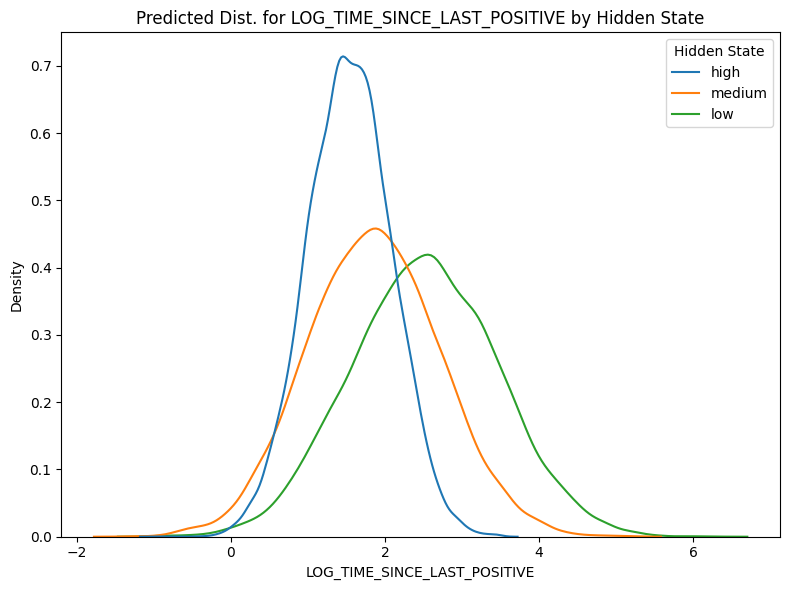

Plotting distribution of NUM_POSITIVES_SINCE_LAST_NEGATIVE for each hidden state.


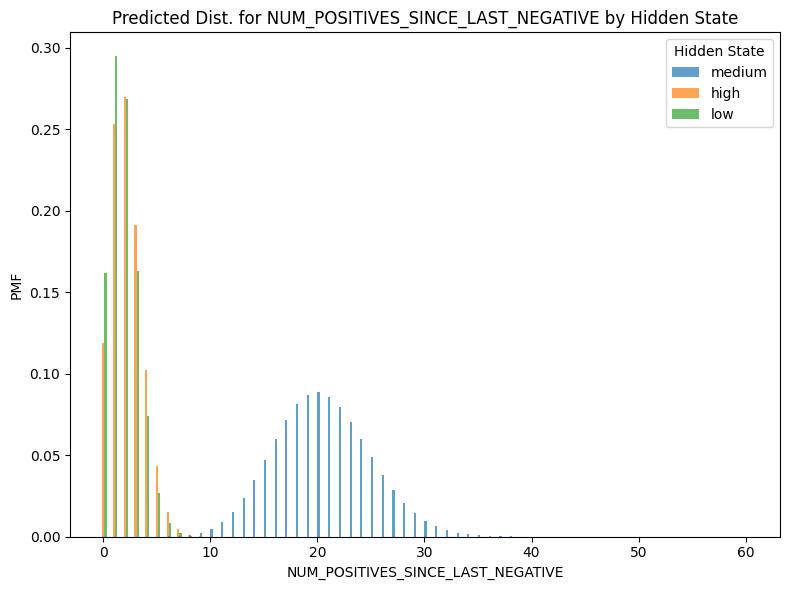

Plotting distribution of RELAPSE_DURATION_CATEGORY_ENCODED for each hidden state.


In [27]:
from recurrent_health_events_prediction.training.utils_hmm import (
    plot_feature_distribution_per_hidden_state,
)

for feature, dist in hmm.features.items():
    print(f"Plotting distribution of {feature} for each hidden state.")
    save_path = os.path.join(save_dir, f"pred_{feature}_dist.png")
    plot_feature_distribution_per_hidden_state(
        feature, distributions_params_df, hue_order=labels, save_file=None
    )

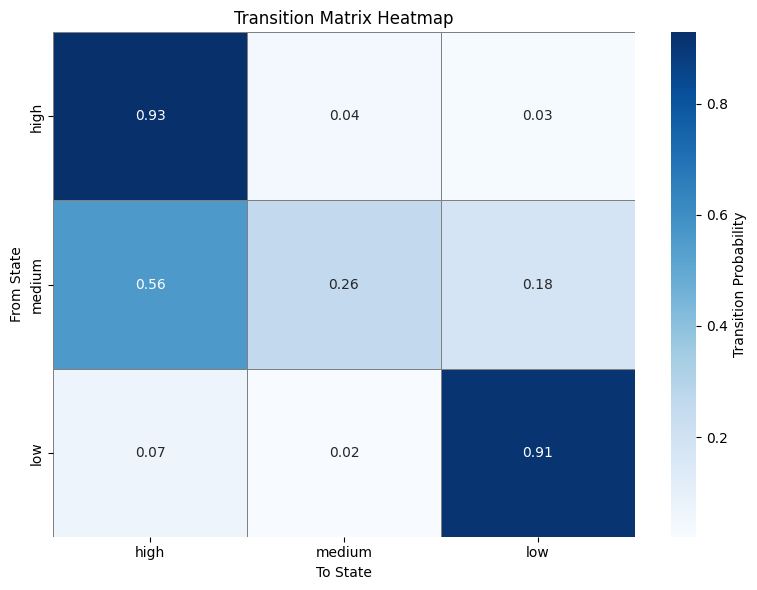

In [28]:
from recurrent_health_events_prediction.training.utils_hmm import plot_transition_matrix_heatmap

transition_matrix = hmm.get_transition_matrix()
# Create a DataFrame for the transition matrix with labeled rows and columns
transition_matrix_df = pd.DataFrame(
    transition_matrix,
    index=[hidden_states_mapping[i] for i in range(len(transition_matrix))],
    columns=[hidden_states_mapping[i] for i in range(len(transition_matrix))]
)

# Display the DataFrame
transition_matrix_df = transition_matrix_df.loc[labels, labels]

fig = plot_transition_matrix_heatmap(transition_matrix_df)

In [29]:
if SAVE_MODEL_AND_RESULTS:
    hmm.save_model_params()

Saving model parameters to /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/hmm_categorical_relapse_time_params.txt


#### Inference

In [30]:
pred_seq = hmm.infer_hidden_states(X)

In [31]:
pred_proba = hmm.predict_proba(X)

In [32]:
from recurrent_health_events_prediction.training.utils_hmm import summarize_hidden_state_counts_from_df

hidden_states_count_df = summarize_hidden_state_counts_from_df(X, hmm, subject_id_col=subject_id_col)
hidden_states_count_df.head()

HEALTH_HIDDEN_RISK,DONOR_ID,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_MEDIUM
0,10141,0,4,0
1,10173,1,0,0
2,10219,5,6,0
3,10731,0,2,0
4,10813,30,0,0


Assign hidden states to observations

In [ ]:
from recurrent_health_events_prediction.training.utils_hmm import add_pred_state_to_df, add_pred_prob_states_to_df

training_seq_with_probs_df = add_pred_state_to_df(X, pred_seq, labels_dict=hidden_states_mapping)
training_seq_with_probs_df = add_pred_prob_states_to_df(X, pred_proba, labels=hidden_states_mapping)
training_seq_with_probs_df

Save observations/sequences of hmm training with hidden states

In [34]:
# Save the DataFrame to a CSV file
if SAVE_MODEL_AND_RESULTS:
    print("Saving training sequences with predicted states and probabilities to CSV.")
    os.makedirs(save_dir, exist_ok=True)
    training_seq_with_probs_df.to_csv(os.path.join(save_dir, "training_seq_with_probs.csv"), index=False)
else:
    print("Not saving the training sequences with predicted states and probabilities to CSV as SAVE_MODEL_AND_RESULTS is set to False.")

Saving training sequences with predicted states and probabilities to CSV.


In [35]:
if SAVE_MODEL_AND_RESULTS:
    print("Saving model...")
    hmm.save_model()
else:
    print("Not saving the model as SAVE_MODEL_AND_RESULTS is set to False.")

Saving model...
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/hmm_categorical_relapse_time.pkl
Saving model config to /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/hmm_categorical_relapse_time_config.yaml


Plot saved to /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/relapse_time_by_hidden_state.png


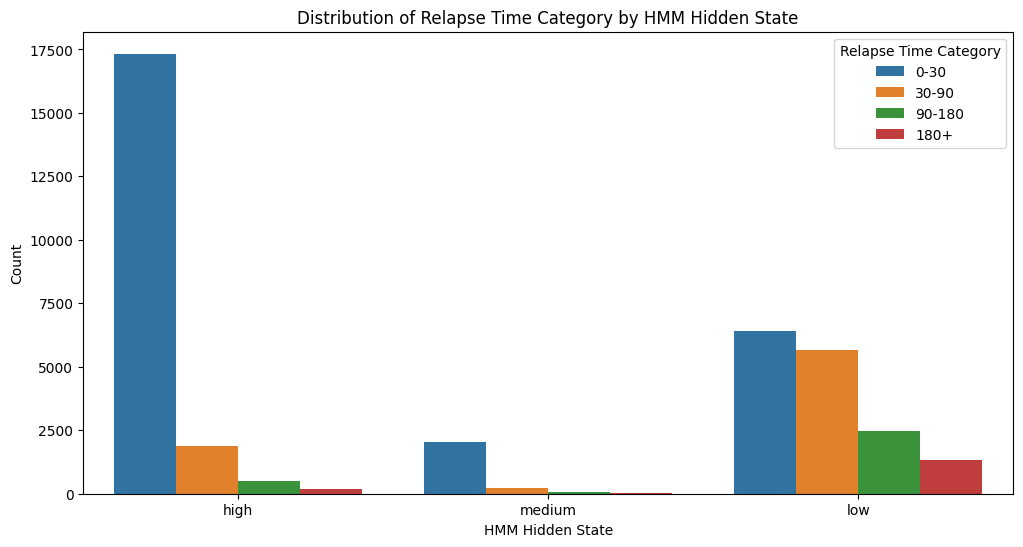

In [36]:
from recurrent_health_events_prediction.training.utils_hmm import plot_cat_event_time_by_hidden_state
save_file = os.path.join(save_dir, f"{event_name}_time_by_hidden_state.png") if SAVE_MODEL_AND_RESULTS else None
fig = plot_cat_event_time_by_hidden_state(training_seq_with_probs_df,
                                          time_cat_col=event_time_cat_col,
                                          hue_order=event_time_cat_order,
                                          hidden_states_order=labels,
                                          save_file=save_file, event_name=event_name)

Plot saved to /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/log_time_until_next_positive_by_hidden_state.png


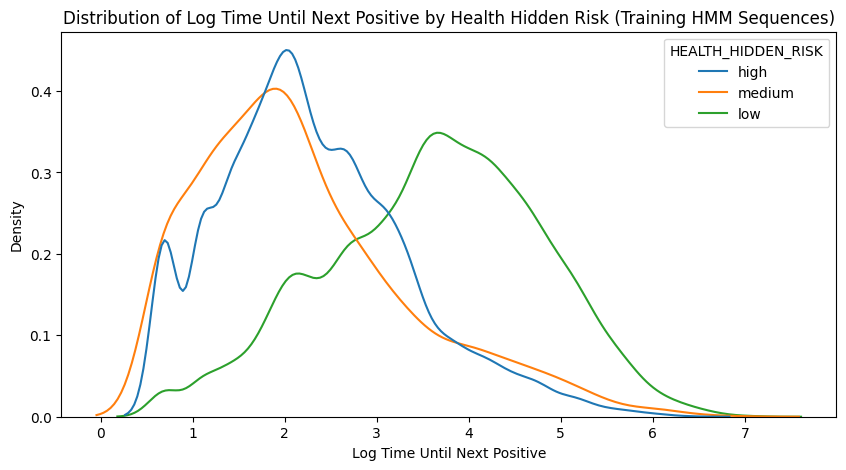

In [37]:
from recurrent_health_events_prediction.training.utils_hmm import plot_feature_kde_by_hidden_state

filename = f"{continuous_event_time_col.lower()}_by_hidden_state.png"
save_file = os.path.join(save_dir, filename) if SAVE_MODEL_AND_RESULTS else None
fig = plot_feature_kde_by_hidden_state(
        continuous_event_time_col,
        training_seq_with_probs_df,
        hidden_state_col='HEALTH_HIDDEN_RISK',
        hue_order=labels,
        show_plot=True,
        suffix_title='(Training HMM Sequences)',
        save_path=save_file
    )

## Results

In [ ]:
X.head(20)

In [39]:
subject_ids = X[subject_id_col].drop_duplicates().tolist()

Example

In [40]:
subject_id = 10141
patient_idx = subject_ids.index(subject_id)

pred_seq_patient = list(map(lambda x: hidden_states_mapping[x], pred_seq[patient_idx]))
pred_proba_patient = pred_proba[patient_idx]

print(f"Patient ID: {X[subject_id_col].unique()[patient_idx]}")
print("Predicted hidden state sequence: ", pred_seq_patient)
print("Predicted probabilities for each hidden state:")
print(pred_proba_patient)

Patient ID: 10141
Predicted hidden state sequence:  ['low', 'low', 'low', 'low']
Predicted probabilities for each hidden state:
[[9.862798577842113e-09, 0.05845028907060623, 0.94154953956604], [1.9450101529372432e-09, 4.4724893086822703e-05, 0.9999561309814453], [1.530300863805678e-08, 0.019111771136522293, 0.9808883666992188], [1.9095742764818624e-09, 0.015108075924217701, 0.984892725944519]]


In [41]:
print(f"Patient ID: {subject_id}")
X[X[subject_id_col] == subject_id]

Patient ID: 10141


,DONOR_ID,COLLECTION_ID,RELAPSE_START,RELAPSE_END,EVENT_DURATION,RELAPSE_EVENT,NUM_TESTS_PERIOD,NUM_PREV_RELAPSES,RELAPSE_DURATION_CATEGORY,RELAPSE_DURATION_CATEGORY_ENCODED,...,FENTANYL_POS,KETAMINE_POS,KRATOM_POS,LSD_POS,METHADONE_POS,OPIATES_POS,OPIOIDS_POS,OTHER_POS,ZOLPIDEM_POS,HEALTH_HIDDEN_RISK
0,10141,1860777,2015-07-02,2015-07-08,6.0,1,1,0,0-30,0,...,0,0,0,0,0,0,0,0,0,low
1,10141,2006469,2015-09-04,2015-11-12,69.0,1,4,1,30-90,1,...,0,0,0,0,0,0,0,0,0,low
2,10141,2198385,2015-11-23,2015-12-09,16.0,1,2,2,0-30,0,...,0,0,0,0,0,0,0,0,0,low
3,10141,2260474,2015-12-21,2016-01-19,29.0,1,1,3,0-30,0,...,0,0,0,0,0,0,0,0,0,low


In [42]:
from recurrent_health_events_prediction.visualization.utils import plot_subject_evolution
from recurrent_health_events_prediction.visualization.utils import plot_hidden_risk_states_patient, generate_color_mapping_with_plotly

save_file_path = os.path.join(save_dir, f"subject_evolution_{subject_id}.html") if SAVE_MODEL_AND_RESULTS else None
data = pred_proba[patient_idx]

if DATASET == "mimic":
    features_to_plot = ["CHARLSON_INDEX", "HOSPITALIZATION_DAYS", "DAYS_IN_ICU", "NUM_DRUGS", "NUM_PROCEDURES", "DAYS_UNTIL_NEXT_HOSPITALIZATION"]
    plot_subject_evolution(X, subject_id, features_to_plot=features_to_plot, textposition="auto", extend_time_horizon_by=30, save_html_file_path=save_file_path)

data = pred_proba[patient_idx]

filepath = os.path.join(save_dir, f"hidden_risk_states_patient_{subject_id}.html") if SAVE_MODEL_AND_RESULTS else None
color_mapping = generate_color_mapping_with_plotly(labels, color_scale_name="Viridis")
plot_hidden_risk_states_patient(data, hidden_states_mapping, colors=color_mapping, save_html_file_path=filepath)

Plot saved as /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/hidden_risk_states_patient_10141.html


Main metrics

In [43]:
print("Total number of parameters in the model: ", hmm.get_total_num_params())
log_likelihood, num_sequences = hmm.log_likelihood(X)
print(f"Log likelihood of the model: {round(log_likelihood, 2)}")
print(f"Number of sequences: {num_sequences}")
print(F"AIC: ", round(hmm.calculate_aic(X), 2))
print(F"BIC: ", round(hmm.calculate_bic(X), 2))

Total number of parameters in the model:  26
Log likelihood of the model: -189904.28
Number of sequences: 12289
AIC:  379860.55
BIC:  380053.38


In [45]:
if SAVE_MODEL_AND_RESULTS:
    hmm.save_model_metrics(X)
else:
    print("Model metrics not saved, set SAVE_MODEL_AND_RESULTS to True to save them.")

Saving model metrics to /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_categorical_relapse_time/hmm_categorical_relapse_time_metrics.txt


## Model Selection based on AIC and BIC

In [8]:
from recurrent_health_events_prediction.model_selection.hmm import model_selection_hmm

aic_results_dict, bic_results_dict, hmm_model_selection_results = model_selection_hmm(hmm_config_path=config_path,
                    training_data_path=training_data_path,
                    data_config_path=(impresources.files(configs) / 'data_config.yaml'),
                    dataset=DATASET,
                    max_attempts_per_fit=7,
                    n_repeats=5,
                    max_num_states=7,
                    log_in_neptune=True,
                    show_plot=True)

HMM Selection Configuration:
Model Name: hmm_gamma_relapse_time
Max Number of States: 7
Number of Repeats: 5
Max Attempts per Fit: 7
Use Only Sequences with >= 2 Steps: False
Features: {'TIME_SINCE_LAST_NEGATIVE': 'gamma', 'TIME_SINCE_LAST_POSITIVE': 'gamma', 'TIME_UNTIL_NEXT_POSITIVE': 'gamma', 'NUM_POSITIVES_SINCE_LAST_NEGATIVE': 'poisson'}


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/LucasAncken-MasterThesis/RecurrentHealthEventsPrediction/e/REC-75
Loading data from:  /workspaces/master-thesis-recurrent-health-events-prediction/data/avh-data-preprocessed/relapse_cleaned
Data loaded successfully. Preparing data...
Using all sequences, including those with 1 step.
Logging HMM selection configuration to Neptune...
Training HMM models with max number of hidden states: 7
Features:  {'TIME_SINCE_LAST_NEGATIVE': 'gamma', 'TIME_SINCE_LAST_POSITIVE': 'gamma', 'TIME_UNTIL_NEXT_POSITIVE': 'gamma', 'NUM_POSITIVES_SINCE_LAST_NEGATIVE': 'poisson'}


100%|██████████| 6/6 [37:08<00:00, 371.40s/it]


Minimum aic: 1126676.8968955993 at 7 states
Minimum bic: 1127396.9150693696 at 7 states


Plotly figure logged to Neptune run:  bic.html
Plotly figure logged to Neptune run:  aic.html
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 10 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/LucasAncken-MasterThesis/RecurrentHealthEventsPrediction/e/REC-75/metadata


In [12]:
aic_results_dict

{'metric_name': 'aic',
 'best_num_states': 7,
 'best_metric_value': 1126676.8968955993,
 'best_metric_std': 22671.027433586733}

In [13]:
bic_results_dict

{'metric_name': 'bic',
 'best_num_states': 7,
 'best_metric_value': 1127396.9150693696,
 'best_metric_std': 22671.027433586733}

In [15]:
hmm_model_selection_results

{'num_states': [2, 3, 4, 5, 6, 7],
 'num_params': [17.0, 29.0, 43.0, 59.0, 77.0, 97.0],
 'aic_mean': [1236599.7019752502,
  1188881.9947879792,
  1144766.5663703918,
  1129887.8149482727,
  1134440.1921844482,
  1126676.8968955993],
 'aic_std': [23574.00561821363,
  38919.22848892778,
  1772.4641549421235,
  42.78364025401405,
  25605.640823368904,
  22671.027433586733],
 'bic_mean': [1236725.8907273542,
  1189097.2579533332,
  1145085.7496845373,
  1130325.7641467515,
  1135011.753002802,
  1127396.9150693696],
 'bic_std': [23574.00561821363,
  38919.22848892778,
  1772.4641549421235,
  42.78364025401405,
  25605.640823368904,
  22671.027433586733]}